CHARGEMENT DU MODELE

In [2]:
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('MODEL_VAC.h5')


In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import time
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
import math

CODE 1 LIMITE SUP GRAS

In [43]:
import cv2
import numpy as np

# Chargement de l'image
image = cv2.imread('./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png')

if image is None:
    print("Erreur : L'image n'a pas pu être chargée.")
    exit()

# Seuil d'acceptation
differenceThresold = 70

# Limites de la couche du gras
topLimit = []
bottomLimit = []

# Recadrage manuel autour du nucleus medius
# Assurez-vous que 'xmin' et 'xmax' sont définis avant cette ligne ou remplacez-les par des valeurs appropriées
# Vérifiez également que la fonction reframeImage est définie

#image = reframeImage(image, xmin, xmax, 0, 67)  # Si la fonction n'existe pas, il faut la définir.

# Recherche des pixels qui délimitent la couche de gras
for x in range(xmin, xmax+1):
    color = image[0][x][2]  # Composante rouge (canal 2 en BGR)
    layers = 0
    for y in range(0, image.shape[0]):
        if layers > 1:
            break

        if abs(int(image[y][x][2]) - color) > differenceThresold:
            if layers == 0:
                topLimit.append((x, y))
                color = int(image[y][x][2])  # Mettre à jour la couleur pour la prochaine comparaison
                image[y][x] = [0, 0, 255]    # Colorer en rouge
            layers += 1


# AGRANDIR L'IMAGE AFFICHEE
scale_percent = 500  # Ajuster ce pourcentage si l'image est trop grande ou trop petite
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
image = cv2.resize(image, (width, height))


# Affichage de l'image avec les marquages
cv2.namedWindow("Epaisseur minimale de la couche de gras", cv2.WINDOW_AUTOSIZE)
cv2.imshow("Epaisseur minimale de la couche de gras", image)

# Calcul de l'épaisseur minimale de la couche de gras
# Assurez-vous que la fonction findSmallestThickness est définie
distance, cords = findSmallestThickness(topLimit, bottomLimit)

print(f"Epaisseur minimale de la couche de gras: {distance} pixels")
print(f"Points retenus : {cords}\n")
print(topLimit)
# Marquage des points retenus en bleu
#image[cords[0][1], cords[0][0]] = [255, 0, 0]  # Premier point en bleu
#image[cords[1][1], cords[1][0]] = [255, 0, 0]  # Deuxième point en bleu

# Afficher à nouveau l'image avec les points marqués
cv2.imshow("Epaisseur minimale de la couche de gras", image)

# Attendre que l'utilisateur ferme la fenêtre
cv2.waitKey(0)
cv2.destroyAllWindows()


Epaisseur minimale de la couche de gras: 10000 pixels
Points retenus : []

[(41, 41), (42, 40), (43, 40), (44, 40), (45, 39), (46, 39), (47, 39), (48, 38), (49, 38), (50, 37), (51, 37), (52, 36), (53, 36), (54, 36), (55, 36), (56, 35), (57, 34), (58, 34), (59, 33), (60, 33), (61, 33), (62, 33), (63, 32), (64, 32), (65, 32), (66, 31), (67, 31), (68, 31), (69, 31), (70, 31), (71, 30), (72, 30), (73, 30), (74, 30), (75, 30), (76, 30), (77, 29), (78, 29), (79, 29), (80, 29), (81, 29), (82, 29), (83, 29), (84, 29), (85, 28), (86, 28), (87, 28), (88, 28), (89, 28), (90, 27), (91, 27), (92, 27), (93, 27), (94, 26), (95, 26), (96, 26), (97, 26), (98, 26), (99, 25), (100, 25), (101, 25), (102, 25), (103, 25), (104, 25), (105, 25), (106, 26), (107, 26), (108, 25), (109, 26), (110, 26), (111, 26), (112, 26), (113, 26), (114, 26), (115, 26), (116, 26), (117, 26), (118, 26), (119, 26), (120, 26), (121, 26), (122, 26), (123, 26), (124, 26), (125, 26), (126, 26), (127, 26), (128, 25), (129, 25), (130

CODE 2 CALCUL COORD LIM MUSCLE TAB

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Limite inférieure trouvée : [(41, 73), (42, 71), (43, 69), (44, 68), (45, 67), (46, 65), (47, 64), (48, 63), (49, 61), (50, 61), (51, 60), (52, 59), (53, 58), (54, 58), (55, 57), (56, 56), (57, 56), (58, 55), (59, 55), (60, 54), (61, 54), (62, 54), (63, 53), (64, 53), (65, 53), (66, 52), (67, 52), (68, 52), (69, 52), (70, 51), (71, 51), (72, 51), (73, 51), (74, 51), (75, 50), (76, 50), (77, 50), (78, 50), (79, 50), (80, 50), (81, 49), (82, 49), (83, 49), (84, 49), (85, 48), (86, 48), (87, 48), (88, 48), (89, 48), (90, 48), (91, 47), (92, 47), (93, 47), (94, 47), (95, 47), (96, 47), (97, 46), (98, 46), (99, 46), (100, 46), (101, 46), (102, 46), (103, 46), (104, 46), (105, 46), (106, 46), (107, 46), (108, 46), (109, 46), (110, 46), (111, 46), (112, 46), (113, 46), (114, 46), (115, 46), (116, 46), (117, 46), (118, 46), (119, 46), (120, 46), (121, 46), (122, 46), (123, 46), (124, 46), (125, 46), (126, 46), (127, 46), (128, 45), (129, 45), (130, 45), (131

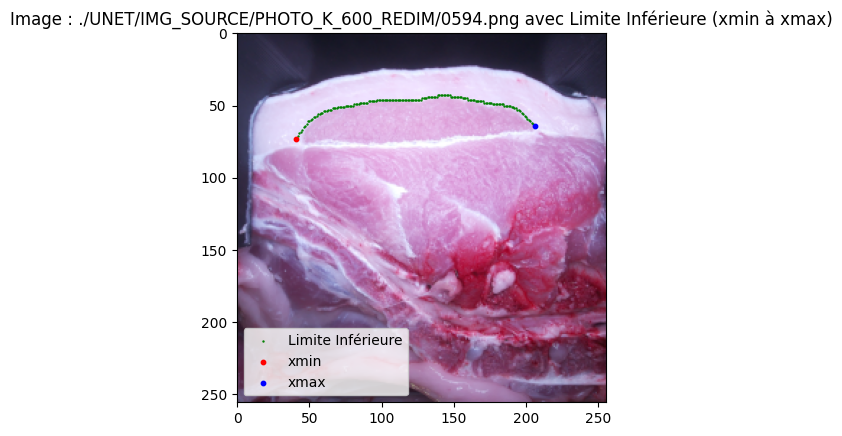

[(41, 73), (42, 71), (43, 69), (44, 68), (45, 67), (46, 65), (47, 64), (48, 63), (49, 61), (50, 61), (51, 60), (52, 59), (53, 58), (54, 58), (55, 57), (56, 56), (57, 56), (58, 55), (59, 55), (60, 54), (61, 54), (62, 54), (63, 53), (64, 53), (65, 53), (66, 52), (67, 52), (68, 52), (69, 52), (70, 51), (71, 51), (72, 51), (73, 51), (74, 51), (75, 50), (76, 50), (77, 50), (78, 50), (79, 50), (80, 50), (81, 49), (82, 49), (83, 49), (84, 49), (85, 48), (86, 48), (87, 48), (88, 48), (89, 48), (90, 48), (91, 47), (92, 47), (93, 47), (94, 47), (95, 47), (96, 47), (97, 46), (98, 46), (99, 46), (100, 46), (101, 46), (102, 46), (103, 46), (104, 46), (105, 46), (106, 46), (107, 46), (108, 46), (109, 46), (110, 46), (111, 46), (112, 46), (113, 46), (114, 46), (115, 46), (116, 46), (117, 46), (118, 46), (119, 46), (120, 46), (121, 46), (122, 46), (123, 46), (124, 46), (125, 46), (126, 46), (127, 46), (128, 45), (129, 45), (130, 45), (131, 45), (132, 44), (133, 44), (134, 44), (135, 44), (136, 44), (1

In [35]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
img_height, img_width = 256, 256

# Chemin complet de l'image
image_path = './UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png'

# Charger et prétraiter l'image de test
test_img = load_img(image_path, target_size=(img_height, img_width))
test_img_array = img_to_array(test_img) / 255.0  # Normalisation
test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch

# Prédire le masque pour l'image de test
predicted_mask = model.predict(test_img_array)

# Convertir la prédiction en masque binaire (0 ou 1)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch

# Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
object_pixels = np.where(predicted_mask == 1)

if len(object_pixels[0]) > 0:  # Si des pixels de l'objet sont détectés
    # Récupérer les coordonnées xmin, xmax
    xmin = np.min(object_pixels[1])  # Le minimum des coordonnées x
    xmax = np.max(object_pixels[1])  # Le maximum des coordonnées x

    # Liste pour stocker les coordonnées de la limite inférieure
    lower_boundary = []

    # Trouver les y min correspondant à chaque x entre xmin et xmax (limite inférieure)
    for x in range(xmin, xmax + 1):
        y_values = object_pixels[0][object_pixels[1] == x]  # Obtenir tous les y pour un x donné
        if len(y_values) > 0:  # S'assurer qu'il y a des pixels pour ce x
            y_min = np.min(y_values)  # Le y min pour ce x
            lower_boundary.append((x, y_min))  # Ajouter les coordonnées (x, y_min) à la liste

    # Afficher les coordonnées trouvées
    print(f"Limite inférieure trouvée : {lower_boundary}")

    # Visualiser les points xmin et xmax sur l'image
    plt.imshow(np.squeeze(test_img_array))  # Afficher l'image originale en fond
    plt.scatter([x for x, y in lower_boundary], [y for x, y in lower_boundary], color='green', s=0.5, label='Limite Inférieure')  # Tracer les points verts pour le y min
    plt.scatter(xmin, np.min(object_pixels[0][object_pixels[1] == xmin]), color='red', label='xmin', s=10)  # Point rouge pour xmin
    plt.scatter(xmax, np.min(object_pixels[0][object_pixels[1] == xmax]), color='blue', label='xmax', s=10)  # Point bleu pour xmax
    plt.legend()
    plt.title(f'Image : {image_path} avec Limite Inférieure (xmin à xmax)')
    plt.show()

    # Retourner le tableau de la limite inférieure
    print(lower_boundary)

else:
    print(f"Aucun objet détecté dans l'image {image_path}")



CODE 3 CALCUL EPAISSEUR MIN

In [47]:
import cv2
import math

# Chargement de l'image sur laquelle tu souhaites dessiner
image = cv2.imread('./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png')

# Initialisation des variables pour stocker la distance minimale et les coordonnées
distance = 10000
cords = []

# Calcul de la plus petite distance entre les points de topLimit et lower_boundary
for pixelTop in topLimit:
    for pixelBottom in lower_boundary:
        d = math.sqrt((pixelTop[0] - pixelBottom[0])**2 + (pixelTop[1] - pixelBottom[1])**2)
        if d < distance:
            distance = d
            cords = [pixelTop, pixelBottom]

# Si des coordonnées ont été trouvées, on trace la ligne
if cords:
    # Récupérer les coordonnées des points haut et bas
    pixelTop, pixelBottom = cords

    # Tracer une ligne rouge entre les deux points
    cv2.line(image, (pixelTop[0], pixelTop[1]), (pixelBottom[0], pixelBottom[1]), (0, 0, 255), 1)
    
    
    scale_percent = 500  # Ajuster ce pourcentage si l'image est trop grande ou trop petite
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    image = cv2.resize(image, (width, height))

    # Afficher l'image avec la ligne tracée
    cv2.imshow("Image avec distance minimale", image)
    cv2.waitKey(0)  # Attendre qu'une touche soit pressée pour fermer la fenêtre
    cv2.destroyAllWindows()

# Afficher la distance et les coordonnées des points
print("Distance minimale :", distance)
print("Coordonnées des points :", cords)


Distance minimale : 18.0
Coordonnées des points : [(139, 25), (139, 43)]


CODE COMPLET

In [3]:
import os
import cv2
import math
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from keras.models import load_model

# Charger le modèle U-Net sauvegardé
model = load_model('MODEL_VAC.h5')


image = cv2.imread('./UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0594.png')

if image is None:
    print("Erreur : L'image n'a pas pu être chargée.")
    exit()
    
    
def findSmallestThickness(topLimit,lower_boundary):
    # Initialisation des variables pour stocker la distance minimale et les coordonnées
    distance = 10000
    cords = []

    # Calcul de la plus petite distance entre les points de topLimit et lower_boundary
    for pixelTop in topLimit:
        for pixelBottom in lower_boundary:
            d = math.sqrt((pixelTop[0] - pixelBottom[0])**2 + (pixelTop[1] - pixelBottom[1])**2)
            if d < distance:
                distance = d
                cords = [pixelTop, pixelBottom]
    return(distance,cords)


def measureFatThickness(image,image_path):
    
    
   
                            
    ###################### MeasureMuscleLimit #########################################################################################################
        
    # Paramètres de l'image (doivent correspondre à ceux utilisés pour l'entraînement)
    img_height, img_width = 256, 256
    
    # Charger et prétraiter l'image de test
    test_img = load_img(image_path, target_size=(img_height, img_width))
    test_img_array = img_to_array(test_img) / 255.0  # Normalisation
    test_img_array = np.expand_dims(test_img_array, axis=0)  # Ajouter une dimension pour le batch

    # Prédire le masque pour l'image de test
    predicted_mask = model.predict(test_img_array)

    # Convertir la prédiction en masque binaire (0 ou 1)
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = np.squeeze(predicted_mask)  # Supprimer la dimension du batch

    # Trouver les indices des pixels où l'objet est présent (valeurs de 1 dans le masque)
    object_pixels = np.where(predicted_mask == 1)

    if len(object_pixels[0]) > 0:  # Si des pixels de l'objet sont détectés
        # Récupérer les coordonnées xmin, xmax
        xmin = np.min(object_pixels[1])  # Le minimum des coordonnées x
        xmax = np.max(object_pixels[1])  # Le maximum des coordonnées x

        # Liste pour stocker les coordonnées de la limite inférieure
        lower_boundary = []

        # Trouver les y min correspondant à chaque x entre xmin et xmax (limite inférieure)
        for x in range(xmin, xmax + 1):
            y_values = object_pixels[0][object_pixels[1] == x]  # Obtenir tous les y pour un x donné
            if len(y_values) > 0:  # S'assurer qu'il y a des pixels pour ce x
                y_min = np.min(y_values)  # Le y min pour ce x
                lower_boundary.append((x, y_min))  # Ajouter les coordonnées (x, y_min) à la liste
                image[y_min][x] = [0, 255, 0]
    
    #################################################################################################################################################
    
    
    ###################### MeasureFatLimit ##########################################################################################################
    
    # Seuil d'acceptation
    differenceThresold = 70

    # Limites de la couche du gras
    topLimit = []
    # Recherche des pixels qui délimitent la couche de gras
    for x in range(xmin, xmax+1):
        color = image[0][x][2]  # Composante rouge (canal 2 en BGR)
        layers = 0
        for y in range(0, image.shape[0]):
            if layers > 1:
                break

            if abs(int(image[y][x][2]) - color) > differenceThresold:
                if layers == 0:
                    topLimit.append((x, y))
                    color = int(image[y][x][2])  # Mettre à jour la couleur pour la prochaine comparaison
                    image[y][x] = [0, 255, 0]    # Colorer en rouge
                layers += 1
        
    #################################################################################################################################################
    
    distance, cords = findSmallestThickness(topLimit, lower_boundary)
    if cords:
        # Récupérer les coordonnées des points haut et bas
        pixelTop, pixelBottom = cords

        # Tracer une ligne rouge entre les deux points
        cv2.line(image, (pixelTop[0], pixelTop[1]), (pixelBottom[0], pixelBottom[1]), (0, 0, 255), 1)
        
        
        scale_percent = 500  # Ajuster ce pourcentage si l'image est trop grande ou trop petite
        width = int(image.shape[1] * scale_percent / 100)
        height = int(image.shape[0] * scale_percent / 100)
        image = cv2.resize(image, (width, height))

        # Afficher l'image avec la ligne tracée
        cv2.imshow("Image avec distance minimale", image)
        cv2.waitKey(0)  # Attendre qu'une touche soit pressée pour fermer la fenêtre
        cv2.destroyAllWindows()

    # Afficher la distance et les coordonnées des points
    print("Distance minimale :", distance)
    print("Coordonnées des points :", cords)

   
    

In [7]:
image_path = './UNET/IMG_SOURCE/PHOTO_K_600_REDIM/0600.png'
image = cv2.imread(image_path)
#MeasureFatLimit(image)
#MeasureMuscleLimit(image_path)
measureFatThickness(image, image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Distance minimale : 17.11724276862369
Coordonnées des points : [(141, 31), (139, 48)]
